In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

import src
from src.reload import deep_reload

In [26]:
list(range(0, 10, 2))

[0, 2, 4, 6, 8]

In [30]:
def multiply_and_resample(x, y):

    xg, yg = np.meshgrid(x, y, indexing = 'ij')

    xy = (xg * yg).flatten()

    return np.random.choice(xy, size = x.shape, replace = False)

%timeit multiply_and_resample(np.random.rand(100), np.random.rand(100))

159 µs ± 310 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [38]:
def multiply_and_resample(x, y):

    xg, yg = np.atleast_2d(x, y)

    xy = (xg.T @ yg).flatten()

    return np.random.choice(xy, size = x.shape, replace = False)

%timeit multiply_and_resample(np.random.rand(100), np.random.rand(100))

138 µs ± 254 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [208]:
from scipy.special import factorial

def queuing_time(l, m, c):

    # c2l = (l.std() ** 2) / (l.mean() ** 2)
    # c2m = (m.std() ** 2) / (m.mean() ** 2)

    rho = l / (c * m)

    k = np.arange(0, c, 1)

    p_0 = 1 / (
        sum([(c * rho) ** k / factorial(k) for k in k]) +
        (c * rho) ** c / (factorial(c) * (1 - rho))
    )

    l_q = (p_0 * (l / m) ** c * rho) / (factorial(c) * (1 - rho))

    # w_q = l_q / l * ((c2l + c2m) / 2)
    w_q = l_q / l

    return w_q

<BarContainer object of 20 artists>

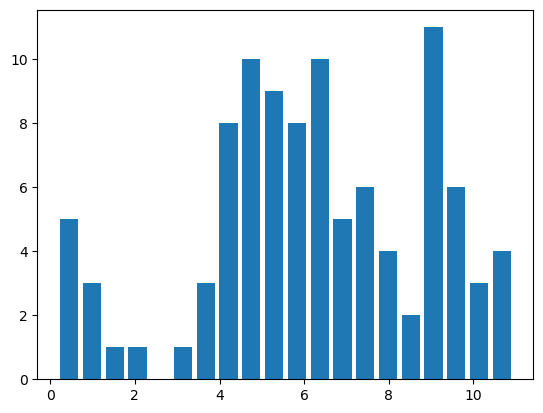

In [210]:
from scipy.stats import uniform, norm, rv_histogram

shape = (100, )

arrival_dist = uniform(loc = 600, scale = 0)
arrival_frequency = 1 / arrival_dist.rvs(size = shape)

charge_energy_dist = norm(loc = 40 * 3.6e6, scale = 15 * 3.6e6)
charge_energy = np.clip(charge_energy_dist.rvs(size = shape), 10e6, 100e6)

charge_rates_dist = rv_histogram([[.6, .4], [80e3, 100e3, 120e3]])
charge_rates = charge_rates_dist.rvs(size = shape)

service_times = multiply_and_resample(charge_energy, 1/charge_rates)

service_frequency = 1 / service_times

# values, bins = np.histogram(service_frequency * 3600)
# width = bins[1] - bins[0]
# locations = bins[:-1] + width / 2
# plt.bar(locations, values, width = .8 * width)

# values, bins = np.histogram(arrival_frequency * 3600)
# width = bins[1] - bins[0]
# locations = bins[:-1] + width / 2
# plt.bar(locations, values, width = .8 * width)

n_servicers = 2

qte = queuing_time(arrival_frequency, service_frequency, n_servicers)

values, bins = np.histogram(qte / 60, bins = 20)
width = bins[1] - bins[0]
locations = bins[:-1] + width / 2
plt.bar(locations, values, width = .8 * width)

<BarContainer object of 20 artists>

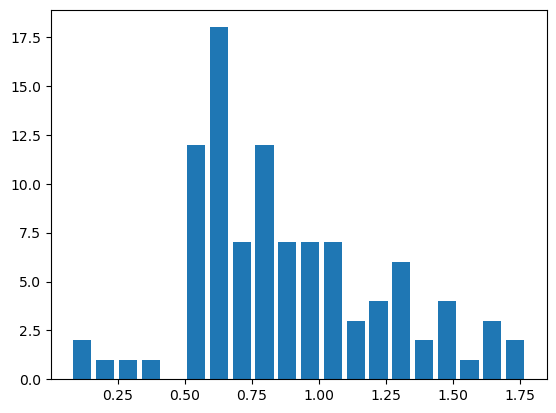

In [188]:
n_servicers = 1

qte = arrival_frequency / (service_frequency * n_servicers)

values, bins = np.histogram(qte, bins = 20)
width = bins[1] - bins[0]
locations = bins[:-1] + width / 2
plt.bar(locations, values, width = .8 * width)

In [64]:
import json

with open('../electric_vrp/routes.json', 'rb') as file:
    routes = json.load(file)

In [66]:
nodes_visited = [r['nodes'] for r in routes]

In [67]:
unique_nodes, unique_counts = np.unique(
    np.concatenate(nodes_visited),
    return_counts = True
)

In [70]:
(unique_counts > 1).sum(), unique_nodes[(unique_counts > 1)]

(3, array([1000000000, 2000000000, 3000000000]))

In [178]:
expected_time = sum([r['time_expected'] for r in routes])

In [179]:
expected_time / 3600

4033.527656035608

In [185]:
expected_trips_riverside = sum([2000000000 in r['nodes'] for r in routes])
expected_trips_riverside / 3 * 16

1914.6666666666667

In [184]:
expected_trips_humboltd = sum([3000000000 in r['nodes'] for r in routes])
expected_trips_humboltd / 3 * 16

90.66666666666667